In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
!pip install -q transformers torch sentencepiece underthesea openpyxl

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from underthesea import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Reshape, Input, Embedding, Conv2D, MaxPool2D, Flatten, Concatenate, Dropout, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import itertools

In [ ]:
df_train = pd.read_csv('/content/df_train_clean.csv')
df_dev   = pd.read_csv('/content/df_dev_clean.csv')
df_test  = pd.read_csv('/content/df_test_clean.csv')

In [ ]:
texts_train, y_train = df_train['content_clean'].fillna('').tolist(), df_train['Toxicity'].tolist()
texts_dev,   y_dev   = df_dev['content_clean'].fillna('').tolist(),   df_dev['Toxicity'].tolist()
texts_test,  y_test  = df_test['content_clean'].fillna('').tolist(),  df_test['Toxicity'].tolist()

In [ ]:
emo_df = pd.read_excel('/content/VnEmoLex.xlsx')
print(emo_df.columns)

Index(['Unnamed: 0', 'Vietnamese', 'Positive', 'Negative',
       'Anger\n/ tức giận', 'Anticipation\n/ Hi vọng',
       'Disgust\n/ chán ghét', 'Fear\n/ sợ hãi', 'Joy\n/ thích thú',
       'Sadness\n/ buồn bã', 'Surprise\n/ ngạc nhiên',
       'Trust\n/ tin tưởng', 'Unnamed: 12'],
      dtype='object')


In [ ]:
toxic_emotions = [
    'Anger\n/ tức giận',
    'Disgust\n/ chán ghét',
    'Fear\n/ sợ hãi',
    'Sadness\n/ buồn bã',
    'Negative'
]
non_toxic_emotions = [
    'Joy\n/ thích thú',
    'Trust\n/ tin tưởng',
    'Anticipation\n/ Hi vọng',
    'Surprise\n/ ngạc nhiên',
    'Positive'
]

In [ ]:
is_toxic = (
    emo_df[toxic_emotions].fillna(0).astype(int).any(axis=1) |
    (emo_df['Negative'].fillna(0).astype(int) == 1)
)

is_non_toxic = (
    emo_df[non_toxic_emotions].fillna(0).astype(int).any(axis=1) |
    (emo_df['Positive'].fillna(0).astype(int) == 1)
)

words = emo_df['Vietnamese'].astype(str)
lex_dict = {
    1: set(words[is_toxic]),
    0: set(words[is_non_toxic])
}

In [ ]:
def lex_features(texts, lexicon_dict=lex_dict):
    feats = []
    labels = sorted(lexicon_dict.keys())  # [0, 1]
    for t in texts:
        toks = word_tokenize(t, format="text").split()
        counts = [sum(1 for w in toks if w in lexicon_dict[l]) for l in labels]
        feats.append(counts)
    return np.array(feats, dtype='float32')

LX_train = lex_features(texts_train, lex_dict)
LX_dev   = lex_features(texts_dev, lex_dict)
LX_test  = lex_features(texts_test, lex_dict)

In [ ]:
print('LX_train.shape:', LX_train.shape)
print('LX_dev.shape:',   LX_dev.shape)
print('LX_test.shape:',  LX_test.shape)
print('Số đặc trưng lexicon:', LX_train.shape[1])  # Sẽ là 2 (non-toxic, toxic)

LX_train.shape: (7000, 2)
LX_dev.shape: (2000, 2)
LX_test.shape: (1000, 2)
Số đặc trưng lexicon: 2


In [ ]:
vocab_size = 20000
tok = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tok.fit_on_texts(texts_train)

In [ ]:
def to_seq(texts, maxlen):
    seq = tok.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')

In [ ]:
X_train_cnn = to_seq(texts_train, 100)
X_dev_cnn   = to_seq(texts_dev,   100)
X_test_cnn  = to_seq(texts_test,  100)

Y_train = np.array(y_train, dtype='float32')
Y_dev   = np.array(y_dev,   dtype='float32')
Y_test  = np.array(y_test,  dtype='float32')

In [ ]:
for name, arr in [
    ("X_train_cnn", X_train_cnn), ("LX_train", LX_train), ("Y_train", Y_train),
    ("X_dev_cnn",   X_dev_cnn),   ("LX_dev",   LX_dev),   ("Y_dev",   Y_dev)
]:
    print(f"{name:12s} | {arr.dtype}, shape={arr.shape}")

X_train_cnn  | int32, shape=(7000, 100)
LX_train     | float32, shape=(7000, 2)
Y_train      | float32, shape=(7000,)
X_dev_cnn    | int32, shape=(2000, 100)
LX_dev       | float32, shape=(2000, 2)
Y_dev        | float32, shape=(2000,)


In [ ]:
def build_text_cnn_2d_lex(vocab_size, embed_dim=100):
    seq_in = Input(shape=(100,), dtype='int32', name='seq_in')
    lex_in = Input(shape=(2,), dtype='float32', name='lex_in')  # Đặc trưng lexicon 2 chiều

    x = Embedding(vocab_size, embed_dim)(seq_in)
    x = Reshape((100, embed_dim, 1))(x)  # shape for Conv2D

    convs = []
    for k in (1, 2, 3, 5):
        c = Conv2D(filters=32, kernel_size=(k, embed_dim), activation='relu')(x)
        p = MaxPool2D(pool_size=(100 - k + 1, 1))(c)
        convs.append(Flatten()(p))
    x = Concatenate()(convs)
    x = Concatenate()([x, lex_in])    # <<== Kết hợp đặc trưng lexicon!
    x = Dropout(0.2)(x)
    out = Dense(2, activation='softmax')(x)
    model = Model([seq_in, lex_in], out, name='TextCNN2D_Lex')
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
cnn2d_lex = build_text_cnn_2d_lex(vocab_size, 100)
cnn2d_lex.summary()

Model: "TextCNN2D_Lex"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 100)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  2,000,000 │ seq_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 100, 100,  │          0 │ embedding[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 1,    │      3,232 │ reshape[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 99, 1, 32) │      6,432 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 98, 1, 32) │      9,632 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 1, 32) │     16,032 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1, 1, 32)  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 1, 32)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 1, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 1, 32)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 32)        │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lex_in (InputLayer) │ (None, 2)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 130)       │          0 │ concatenate[0][0… │
│ (Concatenate)       │                   │            │ lex_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 130)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,035,590 (7.77 MB)

 Trainable params: 2,035,590 (7.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn2d_lex.fit([X_train_cnn, LX_train], Y_train,
              batch_size=32, epochs=10,
              validation_data=([X_dev_cnn, LX_dev], Y_dev)
              )

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8856 - loss: 0.3885 - val_accuracy: 0.8845 - val_loss: 0.3186
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9072 - loss: 0.2517 - val_accuracy: 0.8965 - val_loss: 0.2876
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9447 - loss: 0.1481 - val_accuracy: 0.8950 - val_loss: 0.3295
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9654 - loss: 0.0949 - val_accuracy: 0.8860 - val_loss: 0.3823
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9787 - loss: 0.0563 - val_accuracy: 0.8755 - val_loss: 0.4447
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9917 - loss: 0.0313 - val_accuracy: 0.8765 - val_loss: 0.5375
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.9972 - loss: 0.0136 - val_accuracy: 0.8740 - val_loss: 0.5870
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.9992 - loss: 0.0074 - 


--- Text-CNN2D+VnEmoLex on Test ---
Accuracy       : 0.8940
Precision-Macro: 0.7257
Recall-Macro   : 0.6735
F1-Micro       : 0.8940
F1-Macro       : 0.6946

              precision    recall  f1-score   support

         0.0     0.9270    0.9562    0.9414       890
         1.0     0.5244    0.3909    0.4479       110

    accuracy                         0.8940      1000
   macro avg     0.7257    0.6735    0.6946      1000
weighted avg     0.8827    0.8940    0.8871      1000



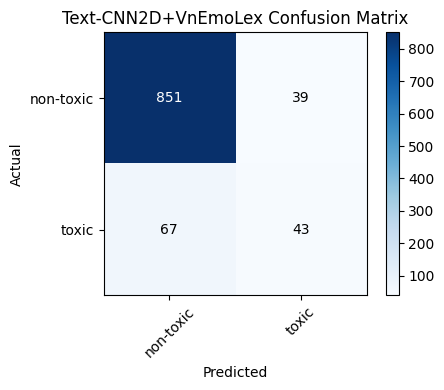

In [ ]:
def eval_and_report_softmax(model, X_seq, LX, y_true, name, thres=0.5):
    y_pred_prob = model.predict([X_seq, LX], verbose=0)
    y_pred = (y_pred_prob[:, 1] >= thres).astype(int)
    acc     = accuracy_score(y_true, y_pred)
    p_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    r_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f_micro = f1_score(y_true, y_pred, average='micro')
    f_macro = f1_score(y_true, y_pred, average='macro')
    print(f"\n--- {name} on Test ---")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision-Macro: {p_macro:.4f}")
    print(f"Recall-Macro   : {r_macro:.4f}")
    print(f"F1-Micro       : {f_micro:.4f}")
    print(f"F1-Macro       : {f_macro:.4f}\n")
    print(classification_report(y_true, y_pred, digits=4))
    labels = [0, 1]
    ticks  = ['non-toxic', 'toxic']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5, 4))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f"{name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, ticks, rotation=45)
    plt.yticks(tick_marks, ticks)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color=color)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

eval_and_report_softmax(cnn2d_lex, X_test_cnn, LX_test, Y_test, 'Text-CNN2D+VnEmoLex')